In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
class FNC(nn.Module):
    # Defines the Neural Network that we're going to use for train our solution
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()
        self.input        = nn.Linear(n_input, n_hidden)          # Define the input later for our NN
        self.hidden       = nn.Linear(n_hidden, n_hidden)     # Defines hidden layers for our NN 
        self.output       = nn.Linear(n_hidden, n_output)         # Define the output layer the NN

    def forward(self, x, y):
        n_layers    = 4
        inputs      = torch.cat([x, y], axis = 1)

        inputs  = self.input(inputs)
        inputs  = torch.sin(inputs)
        
        for i in range(n_layers):
            inputs = self.hidden(inputs)
            inputs = torch.sin(inputs)

        outputs = self.output(inputs)
        outputs = torch.sin(outputs)
        
        return outputs

In [4]:
torch.manual_seed(123)

# Define the hyper parameters of the neural network and the system
n_input     = 2
n_hidden    = 50
n_output    = 1

a   = 0.3        # Velocity of the wave
b   = 0.1

N_domain    = 50
N_bound     = 300
N_initial   = 100
N_train     = 15001

# Define the weights for the loss function
c1  = 1e0
c2  = 1e0
c3  = 1e0

# Create the network
PINN    = FNC(n_input, n_output, n_hidden)
PINN    = PINN.to(device=device)

optimizer       = torch.optim.Adam(PINN.parameters(), lr=1e-3)
loss_values     = [[], [], []]

# Define the domain for the NN
x_domain    = torch.linspace(0, 1, N_domain, device=device)
t_domain    = torch.linspace(0, 5, N_domain, device=device)
t_domain, x_domain = torch.meshgrid(t_domain, x_domain, indexing='ij')

x_domain    = x_domain.reshape(-1, 1).requires_grad_(True)
t_domain    = t_domain.reshape(-1, 1).requires_grad_(True)

# Define the values for the initial and boundary conditions
# For boundary conditions
t_bound     = torch.linspace(0, 5, N_bound, device=device).reshape(-1, 1)
x_bound1    = torch.zeros_like(t_bound).to(device=device)
x_bound2    = torch.ones_like(t_bound).to(device=device)

# For initial condition
x_initial   = torch.linspace(0, 1, N_initial, device=device).reshape(-1, 1)
t_initial   = torch.zeros_like(x_initial).to(device=device)

# Define the initial condition for the wave
def initial_cond(x):
    return 0.25*torch.sin(np.pi*x)

In [5]:
# We train our NN

for train in range(N_train):
    optimizer.zero_grad()

    # We compute all the necessary derivatives to model the system
    u   = PINN(t_domain, x_domain)

    dudt    = torch.autograd.grad(u, t_domain, torch.ones_like(u), create_graph=True)[0]
    dudx    = torch.autograd.grad(u, x_domain, torch.ones_like(u), create_graph=True)[0]
    dudt2   = torch.autograd.grad(dudt, t_domain, torch.ones_like(dudt), create_graph=True)[0]
    dudx2   = torch.autograd.grad(dudx, x_domain, torch.ones_like(dudx), create_graph=True)[0]

    # Then, define the loss function for the EDP
    loss_edp = torch.sum((dudx2 - a*dudt2 - b*dudt)**2)

    # Now, we define the loss function for the initial and boundary conditions
    u_bound1    = PINN(t_bound, x_bound1)
    u_bound2    = PINN(t_bound, x_bound2)
    u_initial   = PINN(t_initial, x_initial)

    loss_bound      = torch.sum((u_bound1)**2) + torch.sum((u_bound2)**2)
    loss_initial    = torch.sum((u_initial - initial_cond(x_initial))**2)

    # Finally, define the loss funtion to optimize and start the optimization process
    loss    = c1*loss_edp + c2*loss_bound + c3*loss_initial
    loss.backward()
    optimizer.step()

    loss_values[0].append(c1*loss_edp.item())
    loss_values[1].append(c2*loss_bound.item())
    loss_values[2].append(c3*loss_initial.item())
    

    if train%1000 == 0:
        print("For iteration "+str(train)+" the loss is given by ", [loss.item(), c1*loss_edp.item(), c2*loss_bound.item(), c3*loss_initial.item()])

For iteration 0 the loss is given by  [2.316631317138672, 0.04647497087717056, 1.1755917072296143, 1.0945645570755005]
For iteration 1000 the loss is given by  [0.4783877730369568, 0.02046346291899681, 0.3393508493900299, 0.11857344210147858]
For iteration 2000 the loss is given by  [0.21396766602993011, 0.01696142554283142, 0.1788749396800995, 0.018131298944354057]
For iteration 3000 the loss is given by  [0.16278930008411407, 0.008126051165163517, 0.14402177929878235, 0.010641468688845634]
For iteration 4000 the loss is given by  [0.14958596229553223, 0.008808181621134281, 0.12972810864448547, 0.011049669235944748]
For iteration 5000 the loss is given by  [0.13894310593605042, 0.0064607588574290276, 0.12553934752941132, 0.006943000480532646]
For iteration 6000 the loss is given by  [0.11529941111803055, 0.0067029958590865135, 0.10202495753765106, 0.006571456789970398]
For iteration 7000 the loss is given by  [0.10177440196275711, 0.005334409885108471, 0.09199409186840057, 0.004445904

In [6]:
def plot(i, j):
    time                = i/(100*t_domain[-1][0].item())
    x_data              = torch.linspace(0, 1, 100, device=device).reshape(-1, 1)
    t_data              = time*torch.ones(100).reshape_as(x_data).to(device=device)
    
    bias_x              = torch.ones_like(x_data)
    # predicted_solution  = PINN(t_data, x_data)-PINN(t_data, bias_x)
    predicted_solution  = PINN(t_data, x_data)

    x_data              = x_data.to(device="cpu")
    x_data              = x_data.detach().numpy()
    predicted_solution  = predicted_solution.to(device="cpu")
    predicted_solution  = predicted_solution.detach().numpy()

    plt.clf()
    plt.plot(x_data, predicted_solution)
    plt.plot(x_data, np.zeros(len(x_data)), color='red')
    plt.ylim([-0.3, 0.3])
    plt.xlabel(u'$x$')
    plt.ylabel(u'$u$')
    plt.grid()

    print('Plot number '+str(i)+' completed')
    
    if j == 0:
        return plt.savefig('images/plot-'+str(i)+'.png', dpi=500)
    
    else:
        return plt.plot()

Plot number 450 completed


[]

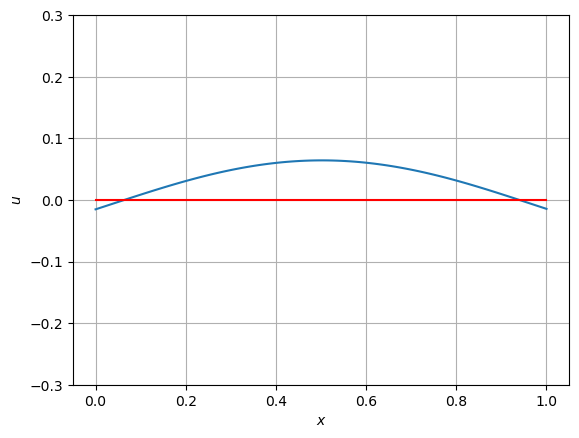

In [12]:
plot(450, 1)

In [8]:
# for i in range(501):
#     plot(i, 0)